In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import brewer2mpl
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_cmap = brewer2mpl.get_map('Dark2', 'Qualitative', 7)
dark2_colors = dark2_cmap.mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import random
import copy
def scatter_by(df, scatterx, scattery, by=None, figure=None, axes=None, colorscale=dark2_cmap, labeler={}, mfunc=None, setupfunc=None, mms=8):
    cs=copy.deepcopy(colorscale.mpl_colors)
    if not figure:
        figure=plt.figure(figsize=(8,8))
    if not axes:
        axes=figure.gca()
    x=df[scatterx]
    y=df[scattery]
    if not by:
        col=random.choice(cs)
        axes.scatter(x, y, cmap=colorscale, c=col)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            mfunc(axeslist,x,y,color=col, mms=mms)
    else:
        cs=list(np.linspace(0,1,len(df.groupby(by))))
        xlimsd={}
        ylimsd={}
        xs={}
        ys={}
        cold={}
        for k,g in df.groupby(by):
            col=cs.pop()
            x=g[scatterx]
            y=g[scattery]
            xs[k]=x
            ys[k]=y
            c=colorscale.mpl_colormap(col)
            cold[k]=c
            axes.scatter(x, y, c=c, label=labeler.get(k,k), s=40, alpha=0.3);
            xlimsd[k]=axes.get_xlim()
            ylimsd[k]=axes.get_ylim()
        xlims=[min([xlimsd[k][0] for k in xlimsd.keys()]), max([xlimsd[k][1] for k in xlimsd.keys()])]
        ylims=[min([ylimsd[k][0] for k in ylimsd.keys()]), max([ylimsd[k][1] for k in ylimsd.keys()])]
        axes.set_xlim(xlims)
        axes.set_ylim(ylims)
        if setupfunc:
            axeslist=setupfunc(axes, figure)
        else:
            axeslist=[axes]
        if mfunc:
            for k in xs.keys():
                mfunc(axeslist,xs[k],ys[k],color=cold[k], mms=mms);
    axes.set_xlabel(scatterx);
    axes.set_ylabel(scattery);
    
    return axes

def make_rug(axeslist, x, y, color='b', mms=8):
    axes=axeslist[0]
    zerosx1=np.zeros(len(x))
    zerosx2=np.zeros(len(x))
    xlims=axes.get_xlim()
    ylims=axes.get_ylim()
    zerosx1.fill(ylims[1])
    zerosx2.fill(xlims[1])
    axes.plot(x, zerosx1, marker='|', color=color, ms=mms)
    axes.plot(zerosx2, y, marker='_', color=color, ms=mms)
    axes.set_xlim(xlims)
    axes.set_ylim(ylims)
    return axes

In any learning problem, or goal is **to minimize the prediction error on the test set**. This prediction error could be a root mean square error, or a 1-0 loss function, or a log likelyhood, or something else.

## Polynomial regression

This part of the lab is partly taken from

http://raw.github.com/jakevdp/sklearn_pycon2013/master/notebooks/09_validation_and_testing.ipynb. Images are taken from Andrew Ng's Coursera course, on which the above notebook is based.

In [3]:
np.random.seed(42)

Consider the model selection problem: what degree of polynomial you want to fit: `d`. It acts like a hyperparameter, in the sense that it is a second parameter that needs to be fit for. Once you set it, you still have to fit the parameters of your linear or polynomial or elsewise model.

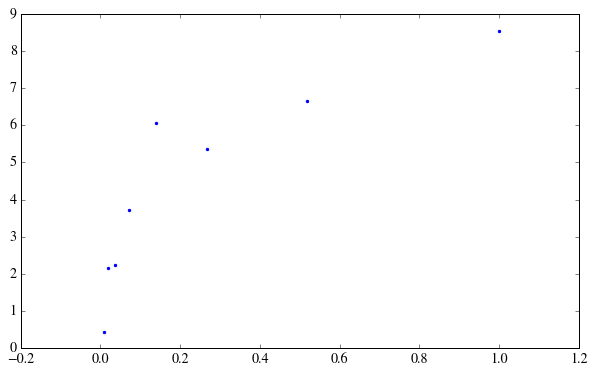

In [5]:
def rmse(p,x,y):
    yfit = np.polyval(p, x)
    return np.sqrt(np.mean((y - yfit) ** 2))

def generate_curve(x, sigma):
    return np.random.normal(10 - 1. / (x + 0.1), sigma)

x = 10 ** np.linspace(-2, 0, 8)
intrinsic_error=1.
y=generate_curve(x, intrinsic_error)
plt.scatter(x,y)

A high bias situation is one in which we underfit. Notice how for low d, the `rmse` on the training set remains high. A high variance situation is one in which we overfit. We want to be just right. As we get to the limit of being able to interpolate the points, the rmse training error goes to nil.

d=1, rmse= 1.33589440198
d=2, rmse= 1.04062558946
d=4, rmse= 0.367597775647
d=6, rmse= 0.264218289923


(-1, 12)

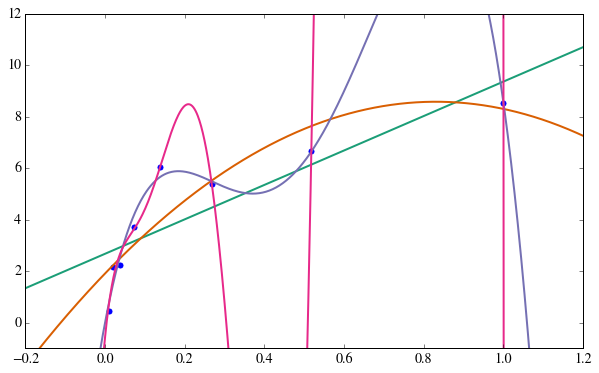

In [9]:
x_new=np.linspace(-0.2, 1.2, 1000)
plt.scatter(x,y, s=50)
f1=np.polyfit(x,y,1)
plt.plot(x_new,np.polyval(f1,x_new))
print("d=1, rmse=",rmse(f1,x,y))
f2=np.polyfit(x,y,2)
plt.plot(x_new,np.polyval(f2,x_new))
print("d=2, rmse=",rmse(f2,x,y))
f4=np.polyfit(x,y,4)
plt.plot(x_new,np.polyval(f4,x_new))
print("d=4, rmse=",rmse(f4,x,y))
f6=np.polyfit(x,y,6)
plt.plot(x_new,np.polyval(f6,x_new))
print("d=6, rmse=",rmse(f6,x,y))
plt.xlim(-0.2, 1.2)
plt.ylim(-1, 12)

The curves start taking on all kinds of wiggles so as to be able to fit themselves in.

### Constructing a data set

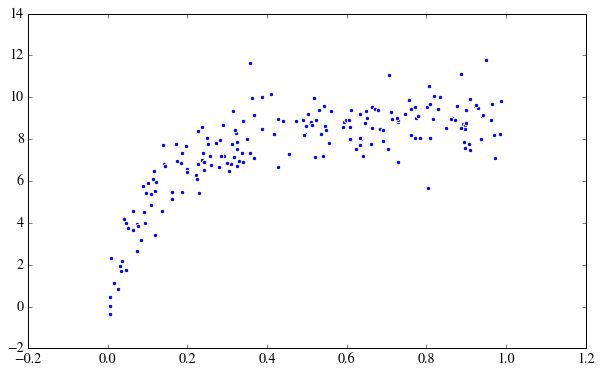

In [16]:
N = 200
x = np.random.random(N)
y = generate_curve(x, intrinsic_error)
plt.scatter(x,y)

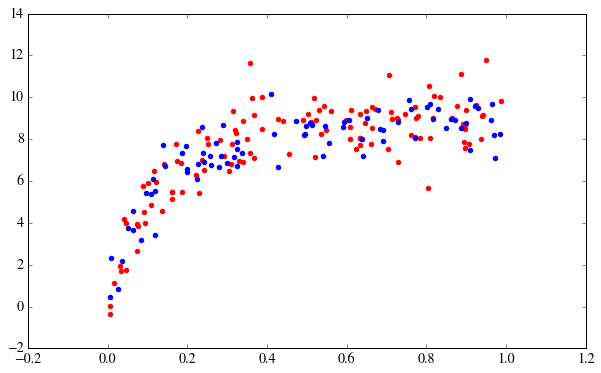

In [17]:
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.6)
plt.scatter(xtrain, ytrain, color='red')
plt.scatter(xtest, ytest, color='blue')

In [18]:
ds = np.arange(21)
train_err = np.zeros(len(ds))
test_err = np.zeros(len(ds))

for i, d in enumerate(ds):
    p = np.polyfit(xtrain, ytrain, d)

    train_err[i] = rmse(p, xtrain, ytrain)
    test_err[i] = rmse(p, xtest, ytest)

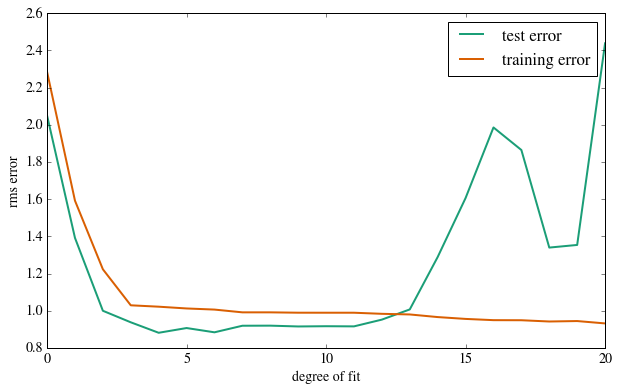

In [19]:
fig, ax = plt.subplots()

ax.plot(ds, test_err, lw=2, label = 'test error')
ax.plot(ds, train_err, lw=2, label = 'training error')
ax.legend(loc=0)
ax.set_xlabel('degree of fit')
ax.set_ylabel('rms error')

How to tell that a hypothesis is overfitting? Its not enough that the training error is low, though thats certainly an indication.

The training error is low but test error is high!

If we plot training error against, say, d, the training error will decrease with increasing d. But for the cross-validation (or for that matter, test error), we'll have an error curve which has a minumum and goes up again.

![polynomial regression](files/data/bias-variance-error.png)

### Learning Curves

Here we plot the train vs cv/test error as a function of the size of the training set.

The training set error increases as size of the data set increases. The intuition is that with more samples, you get further away from the interpolation limit. The cross validation error on the otherhand will decrease as **training set** size increases, as , more
data you have better the hypothesis you fit.

**High Bias**

Now consider the high bias situation. The training error will increase as before, to a point, and then flatten out. (There is only so much you can do to make a straight line fit a quadratic curve). The cv/test error, on the other hand will decrease, but then, it too will flatten out. These will be very close to each other, and after a point, getting more training data will not help!

![Learning Curve under high bias situation](files/data/lc-hb.png)

In [20]:
#taken lock stock and barrel from Vanderplas.
def plot_learning_curve(d):
    sizes = np.linspace(2, N, 50).astype(int)
    train_err = np.zeros(sizes.shape)
    crossval_err = np.zeros(sizes.shape)

    for i, size in enumerate(sizes):
        # Train on only the first `size` points
        p = np.polyfit(xtrain[:size], ytrain[:size], d)
        
        # Validation error is on the *entire* validation set
        crossval_err[i] = rmse(p, xtest, ytest)
        
        # Training error is on only the points used for training
        train_err[i] = rmse(p, xtrain[:size], ytrain[:size])

    fig, ax = plt.subplots()
    ax.plot(sizes, crossval_err, lw=2, label='validation error')
    ax.plot(sizes, train_err, lw=2, label='training error')
    ax.plot([0, N], [intrinsic_error, intrinsic_error], '--k', label='intrinsic error')

    ax.set_xlabel('training set size')
    ax.set_ylabel('rms error')
    
    ax.legend(loc=0)
    
    ax.set_xlim(0, 99)

    ax.set_title('d = %i' % d)

(0, 10)

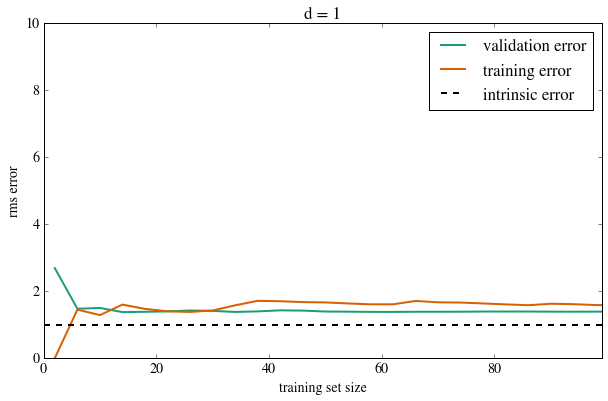

In [21]:
plot_learning_curve(d=1)
plt.ylim(0, 10)

At the point of balance the learning curves come together and carry on, close to the intrinsic error.

(0, 10)

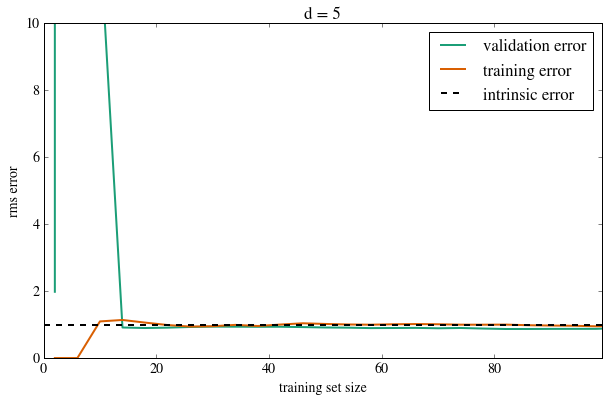

In [25]:
plot_learning_curve(d=5)
plt.ylim(0, 10)

Next consider the high variance situation. The training error will start out very low as usual, and go up slowly as even though we add points, we have enough wiggle room to start with, until it runs out and the error keeps increasing. The cv error, will, on the other hand, start out quite high, and remain high. Thus we will have a gap. In this case it will make sense to take more data, as that would drive the cv error down, and the training error up, until they meet.

![Learning Curve under high variance situation](files/data/lc-hv.png)

(0, 10)

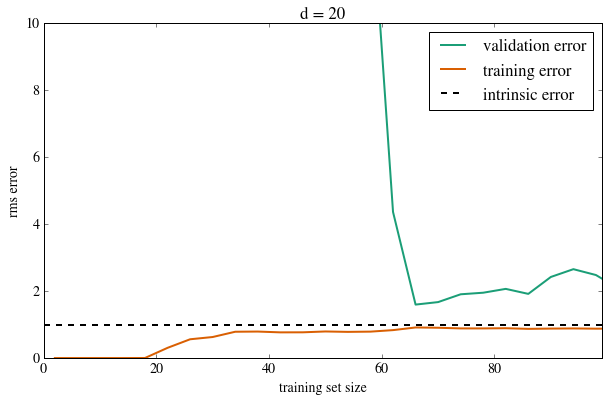

In [26]:
plot_learning_curve(d=20)
plt.ylim(0, 10)

### K-Nearest Neighbors

In [27]:
df=pd.read_csv("data/olive.csv")
df.head(5)

,Unnamed: 0,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,1.North-Apulia,1,1,1075,75,226,7823,672,36,60,29
1,2.North-Apulia,1,1,1088,73,224,7709,781,31,61,29
2,3.North-Apulia,1,1,911,54,246,8113,549,31,63,29
3,4.North-Apulia,1,1,966,57,240,7952,619,50,78,35
4,5.North-Apulia,1,1,1051,67,259,7771,672,50,80,46


In [28]:
df.rename(columns={df.columns[0]:'areastring'}, inplace=True)
df.areastring=df.areastring.map(lambda x: x.split('.')[-1])
acidlist=['palmitic', 'palmitoleic', 'stearic', 'oleic', 'linoleic', 'linolenic', 'arachidic', 'eicosenoic']
dfsub=df[acidlist].apply(lambda x: x/100.0)
df[acidlist]=dfsub
df.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46


In [29]:
dfsouth = df[df.region==1]
dfsouthns = dfsouth[df.area != 4]
dfsouthns.head()

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29
3,North-Apulia,1,1,9.66,0.57,2.40,79.52,6.19,0.50,0.78,0.35
4,North-Apulia,1,1,10.51,0.67,2.59,77.71,6.72,0.50,0.80,0.46


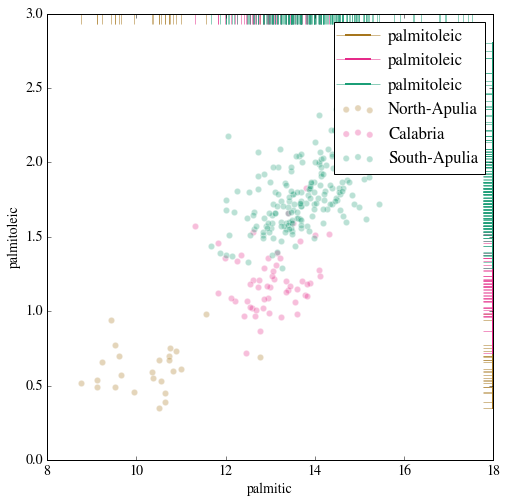

In [30]:
akeys=[1,2,3]
avals=['North-Apulia','Calabria','South-Apulia']
amap={e[0]:e[1] for e in zip(akeys,avals)}
ax=scatter_by(dfsouthns, 'palmitic', 'palmitoleic', by='area', labeler=amap, mfunc=make_rug, mms=20)
ax.grid(False)
ax.legend(loc='upper right');

In [35]:
from matplotlib.colors import ListedColormap
#cm_bright = ListedColormap(['#FF0000', '#000000','#0000FF'])
#cm = plt.cm.RdBu
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def points_plot(X, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    plt.figure()
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cdiscrete, s=50, alpha=0.2,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    print("SCORE", clf.score(Xte, yte))
    plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cdiscrete, alpha=0.5, marker="s", s=35)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    return ax

In [36]:
from sklearn.neighbors import KNeighborsClassifier
subdf=dfsouthns[['palmitic','palmitoleic']]
subdfstd=(subdf - subdf.mean())/subdf.std()
X=subdfstd.values
y=dfsouthns['area'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.6)
Xtr=np.concatenate((Xtrain, Xtest))

We do kNN with 20 neighbors. kNN 

SCORE 0.921739130435


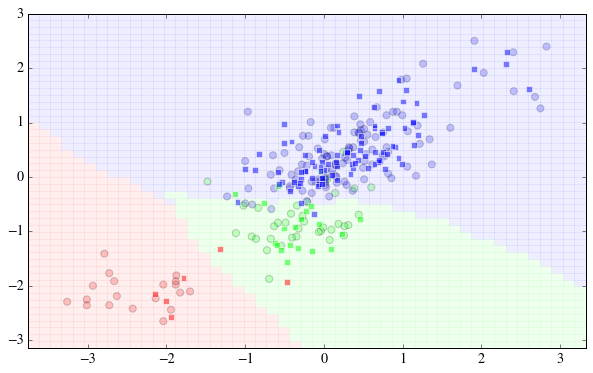

In [38]:
clf = KNeighborsClassifier(20).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

What if we decide to get ultra local. We get high variance and Jagged islands.

SCORE 0.930434782609


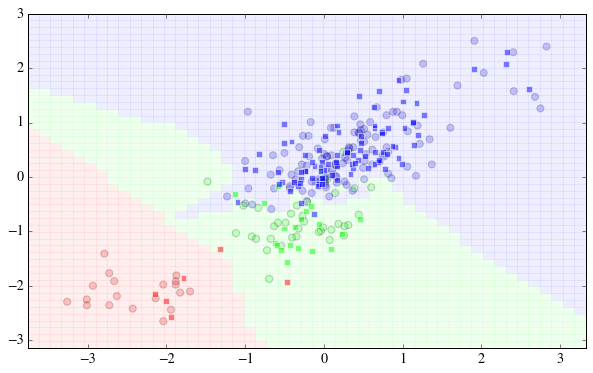

In [39]:
#your code here
clf = KNeighborsClassifier(1).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

You do it for 35 now..see what happens?

SCORE 0.930434782609


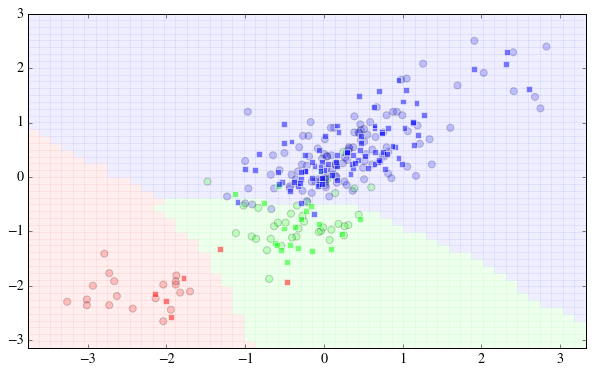

In [41]:
#your code here
clf = KNeighborsClassifier(35).fit(Xtrain, ytrain)
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, clf)

We now start splitting data even more in a strange way. Why do we need to do this?

(172,) (57,) (58,)
0.810344827586


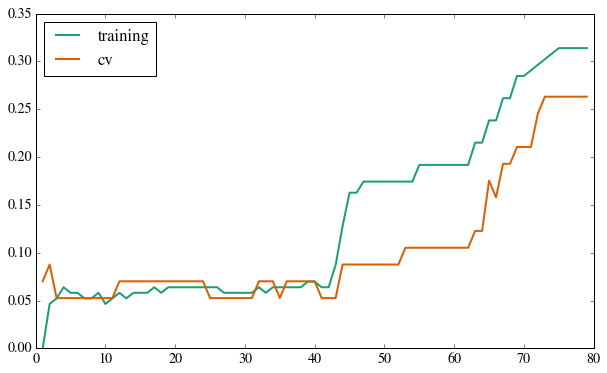

In [50]:
Xcv,Xte,ycv,yte=train_test_split(Xtest, ytest, train_size=0.5)
print(ytrain.shape, ycv.shape, yte.shape)
trscores=[]
cvscores=[]
ns=np.arange(1,80,1)
ones=np.ones(len(ns))
for n in ns:
    clf = KNeighborsClassifier(n).fit(Xtrain, ytrain)
    trscores.append(clf.score(Xtrain, ytrain))
    cvscores.append(clf.score(Xcv, ycv))
plt.plot(ns, ones-trscores, label="training")
plt.plot(ns, ones-cvscores, label="cv")
plt.legend(loc='upper left');
print(clf.score(Xte, yte))

This is the same graph we saw earlier, but rversed..k=1 is high variance!

### train/validate/test

If you fit hyperparameter by finding the lowest test set error, you can ask
how well this model generalize. But this is not likely to be a fair estimate of how well this model generalizes. It is likely to be an optimistic estimate as d is fit to the test set.

So do a 3 way split to train/cv/test and pick hypothesis with lowest cross-validation error. But this might be hard if we didnt have that large a data set.

Practically what we do is to nest our cross-validation inside a grid search. Remember, our hyperparameter fit is also a fit!, and thus the `X_cv` serves as its "data". Thus we need this nesting and 3 way split. Or you would be testing the hyperparameter fit on its own "training" set.

In [51]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)
Xtr=np.concatenate((Xtrain, Xtest))

In [52]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
parameters = {"n_neighbors": np.arange(1,80,1)}
clf = KNeighborsClassifier()
gs = GridSearchCV(clf, param_grid=parameters, cv=10)
gs.fit(Xtrain, ytrain)
#print gs.grid_scores_
print(gs.best_params_, gs.best_score_)
y_true, y_pred = ytest, gs.predict(Xtest)
print(classification_report(y_true, y_pred))

{'n_neighbors': 10} 0.951965065502
             precision    recall  f1-score   support

          1       1.00      0.86      0.92         7
          2       0.80      0.67      0.73        12
          3       0.90      0.97      0.94        39

avg / total       0.89      0.90      0.89        58



SCORE 0.896551724138


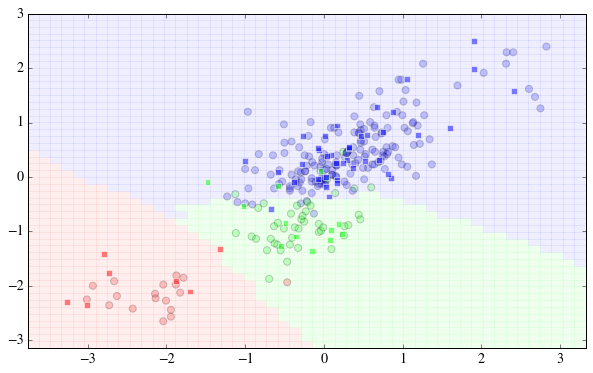

In [53]:
points_plot(Xtr, Xtrain, Xtest, ytrain, ytest, gs)

We've seen the interplay of bias and variance, and we've seen how hyperparameter, here `d` and `k` must be fit by cross-validation, using a nested scheme. 

See Chris's notebook for bad consequences that might arise otherwise! 

(http://nbviewer.ipython.org/urls/raw.github.com/cs109/content/master/lec_10_cross_val.ipynb)

We'd touched on regularization last time, and will revisit regularization next time in the bayesian scheme, and see how regularization parameters control bias and variance.

Finally, we'll put all this together to come up with a strategy for evaluating classifiers and improving our predictions, using this notion of the bias-variance tradeoff, and hyperparameter estimation.